CNN Baseline classifier using train/test split datasets

In [26]:
import os
import numpy as np
import sys
print(sys.executable)
import sys
sys.path.insert(1, '../src/')
from CNN_classifier_model import CNNClassifier, train_model
from config import raw_data_path, univariate_data_path, processed_data_path
from preprocessing_modules import create_time_windows_with_labels
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import wandb
wandb.login(key="5f15eb7efc1e0e939ccc83345338a0b8c24e2fbc")


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


/home/nwertheim/miniconda3/bin/python


True

In [27]:
import wandb

import wandb

# Optional: Define a project name and other metadata
wandb.init(
    project="Baseline CNN classifier",
    name="run-with-class-weights-correct",  # Optional: to name the run
    config={
        "learning_rate": 0.00012403724372113712,
        "epochs": 10,
        "batch_size": 16,
    }
)


train_loss,▆▅▄█▃▄▂▃▄▅▄▃▃▅▄▁▂▅▄▆▆▃▇▅▂▆▆▅▅▃▂▃▂▇▂▂▆▄▄▄
train_loss,0.38567


In [28]:
train_dir = os.path.join(univariate_data_path, "target_univariate_train.npy")
train_data = np.load(train_dir, allow_pickle=True)
# train_data = pd.DataFrame(train_data)
test_dir = os.path.join(univariate_data_path, "target_univariate_test.npy")
test_data = np.load(test_dir, allow_pickle=True)
# test_data = pd.DataFrame(test_data)
print(len(train_data))
print(len(test_data))
print(train_data[0])

train_windows = create_time_windows_with_labels(train_data)
test_windows = create_time_windows_with_labels(test_data)

124
32
{'record_name': np.str_('Hopper-2022_08_24_06_55_46-0000010181-0001'), 'signal': array([[ -8.77326634],
       [-16.30170858],
       [-12.15312614],
       ...,
       [  1.94513686],
       [  0.52803341],
       [  2.90890496]]), 'fs': 20, 'preterm': 1}


In [29]:
learning_rate = 0.00012403724372113712
epochs = 50
batch_size = 16
num_layers = 5
base_channels = 32
device = torch.device(device if torch.cuda.is_available() else "cpu")


In [30]:
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.utils.class_weight import compute_class_weight

from collections import Counter

# Example dataset with windows and labels
train_windows, train_labels = create_time_windows_with_labels(train_data)
test_windows, test_labels = create_time_windows_with_labels(test_data)

# Count label distribution
train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)

# Print the counts
print("Train label distribution:")
print(f"  Term (0): {train_label_counts[0]}")
print(f"  Preterm (1): {train_label_counts[1]}")

print("\nTest label distribution:")
print(f"  Term (0): {test_label_counts[0]}")
print(f"  Preterm (1): {test_label_counts[1]}")

# Convert to tensors
train_windows_tensor = torch.tensor(train_windows, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)
test_windows_tensor = torch.tensor(test_windows, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32)

train_dataset = TensorDataset(train_windows_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_windows_tensor, test_labels_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train label distribution:
  Term (0): 319
  Preterm (1): 752

Test label distribution:
  Term (0): 306
  Preterm (1): 593


In [31]:
# def extract_windows_from_signal(signal, window_size):
#     signal = signal.squeeze()  # (seq_len,)
#     total_length = len(signal)
#     n_windows = total_length // window_size
#     windows = np.array([
#         signal[i * window_size: (i + 1) * window_size]
#         for i in range(n_windows)
#     ])
#     return windows  # shape (n_windows, window_size)

# def create_windowed_dataset(df, window_size):
#     windowed_data = []  

#     for idx, row in df.iterrows():
#         record_name = row[0]['record_name']
#         label = row[0]['preterm']
#         signal = row[0]['signal']  # shape (seq_len, 1)

#         windows = extract_windows_from_signal(signal, window_size)

#         for i, window in enumerate(windows):
#             windowed_data.append({
#                 'record_name': record_name,
#                 'window_id': i,
#                 'window': window.astype(np.float32),
#                 'label': label
#             })

#     return pd.DataFrame(windowed_data)

In [32]:
# class TimeSeriesWindowDataset(Dataset):
#     def __init__(self, dataframe):
#         self.data = dataframe

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         row = self.data.iloc[idx]
#         window = torch.tensor(row['window']).unsqueeze(0)  # shape (1, window_size)
#         label = torch.tensor(row['label'], dtype=torch.float32)
#         return window, label

# def create_dataloaders(train_df, test_df, batch_size=32):
#     train_loader = DataLoader(TimeSeriesWindowDataset(train_df), batch_size=batch_size, shuffle=True)
#     test_loader = DataLoader(TimeSeriesWindowDataset(test_df), batch_size=batch_size, shuffle=False)
#     return train_loader, test_loader


In [33]:
# window_size = 12000

# # 1. Create windows
# train_windows = create_windowed_dataset(train_data, window_size=window_size)
# test_windows = create_windowed_dataset(test_data, window_size=window_size)

# # 3. Create DataLoaders
# train_loader, test_loader = create_dataloaders(train_windows, test_windows)
# print(len(train_loader), len(test_loader))

# def print_class_distribution(df, name="Dataset"):
#     class_counts = df['label'].value_counts().sort_index()
#     total_count = len(df)
    
#     term_count = class_counts.get(0, 0)  # count for term (0)
#     preterm_count = class_counts.get(1, 0)  # count for preterm (1)
    
#     term_ratio = term_count / total_count
#     preterm_ratio = preterm_count / total_count
    
#     print(f"\n{name} class distribution:")
#     print(f"Term (0): {term_count} instances, {term_ratio:.2f} ratio")
#     print(f"Preterm (1): {preterm_count} instances, {preterm_ratio:.2f} ratio")
#     print(f"Total: {total_count} instances")

# # For train and test
# print_class_distribution(train_windows, "Train Set")
# print_class_distribution(test_windows, "Test Set")


In [34]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class CNNClassifier(nn.Module):
#     def __init__(self, input_length):
#         super(CNNClassifier, self).__init__()
        
#         self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=7, padding=3)
#         self.bn1 = nn.BatchNorm1d(16)
        
#         self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
#         self.bn2 = nn.BatchNorm1d(32)
        
#         self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
#         self.bn3 = nn.BatchNorm1d(64)
        
#         self.pool = nn.AdaptiveAvgPool1d(1)
#         self.classifier = nn.Linear(64, 1)

#     def forward(self, x):
#         x = F.relu(self.bn1(self.conv1(x)))  # (B, 16, L)
#         x = F.relu(self.bn2(self.conv2(x)))  # (B, 32, L)
#         x = F.relu(self.bn3(self.conv3(x)))  # (B, 64, L)
        
#         x = self.pool(x).squeeze(-1)         # (B, 64)
#         x = self.classifier(x)               # (B, 1)
#         return x


In [35]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import torch
from sklearn.utils.class_weight import compute_class_weight
import torch

from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

# def train_model(model, train_loader, test_loader, epochs=10, lr=1e-3, device='cuda'):
#     device = torch.device(device if torch.cuda.is_available() else "cpu")
#     model = model.to(device)

#     # Extract labels to compute class weights
#     all_labels = []
#     for _, y_batch in train_loader:
#         all_labels.extend(y_batch.numpy())

#     class_weights = compute_class_weight(
#         class_weight='balanced',
#         classes=np.array([0, 1]),
#         y=np.array(all_labels)
#     )
    
#     pos_weight = torch.tensor(class_weights[1] / class_weights[0], dtype=torch.float).to(device)
#     # criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
#     criterion = nn.BCEWithLogitsLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#     # Lists to store epoch-wise losses
#     train_losses = []
#     test_losses = []

#     for epoch in range(epochs):
#         model.train()
#         epoch_train_loss = 0.0

#         for x_batch, y_batch in train_loader:
#             x_batch = x_batch.unsqueeze(1).to(device)  # Add channel dim: (B, 1, L)
#             y_batch = y_batch.to(device).unsqueeze(1)  # (B,) → (B, 1)

#             optimizer.zero_grad()
#             outputs = model(x_batch)
#             loss = criterion(outputs, y_batch)
#             loss.backward()
#             optimizer.step()

#             epoch_train_loss += loss.item() * x_batch.size(0)

#         avg_train_loss = epoch_train_loss / len(train_loader.dataset)
#         train_losses.append(avg_train_loss)

#         # Evaluate on test set
#         model.eval()
#         epoch_test_loss = 0.0
#         with torch.no_grad():
#             for x_batch, y_batch in test_loader:
#                 x_batch = x_batch.unsqueeze(1).to(device)
#                 y_batch = y_batch.to(device).unsqueeze(1)

#                 outputs = model(x_batch)
#                 loss = criterion(outputs, y_batch)
#                 epoch_test_loss += loss.item() * x_batch.size(0)

#         avg_test_loss = epoch_test_loss / len(test_loader.dataset)
#         test_losses.append(avg_test_loss)

#         print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")

#     # Plot loss curves
#     plt.figure(figsize=(8, 5))
#     plt.plot(train_losses, label="Train Loss", marker='o')
#     plt.plot(test_losses, label="Test Loss", marker='s')
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")
#     plt.title("Training and Test Loss per Epoch")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

#     return model



In [36]:
# from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report
# import seaborn as sns
# import matplotlib.pyplot as plt

# def evaluate_model(model, dataloader, criterion, device='cuda'):
#     model.eval()
#     total_loss = 0.0
#     all_preds = []
#     all_probs = []
#     all_labels = []
#     device = torch.device(device if torch.cuda.is_available() else "cpu")

#     with torch.no_grad():
#         for x_batch, y_batch in dataloader:
#             x_batch = x_batch.to(device)
#             y_batch = y_batch.to(device).unsqueeze(1)

#             outputs = model(x_batch)
#             probs = torch.sigmoid(outputs)
#             loss = criterion(outputs, y_batch)

#             total_loss += loss.item() * x_batch.size(0)

#             all_probs.append(probs.cpu())
#             all_preds.append((probs >= 0.5).float().cpu())
#             all_labels.append(y_batch.cpu())

#     all_probs = torch.cat(all_probs).numpy().flatten()
#     all_preds = torch.cat(all_preds).numpy().flatten()
#     all_labels = torch.cat(all_labels).numpy().flatten()

#     avg_loss = total_loss / len(dataloader.dataset)
#     acc = (all_preds == all_labels).mean()
#     auc = roc_auc_score(all_labels, all_probs)
#     ap = average_precision_score(all_labels, all_probs)
    
#     print(f"Loss: {avg_loss:.4f} | Acc: {acc:.4f} | AUC: {auc:.4f} | AP: {ap:.4f}")
    
#     # Print classification report
#     print("\nClassification Report:")
#     print(classification_report(all_labels, all_preds, digits=4))

#     # Plot confusion matrix
#     cm = confusion_matrix(all_labels, all_preds)
#     plot_confusion_matrix(cm, class_names=["Term", "Preterm"])
    
#     return avg_loss, acc, auc, ap

# def plot_confusion_matrix(cm, class_names):
#     plt.figure(figsize=(6, 5))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
#                 xticklabels=class_names, yticklabels=class_names)
#     plt.xlabel("Predicted")
#     plt.ylabel("True")
#     plt.title("Confusion Matrix")
#     plt.tight_layout()
#     plt.show()


Epoch 1/10 | Test Loss (pre-update): 0.4317 | Train Loss: 0.4005
Epoch 2/10 | Test Loss (pre-update): 0.4672 | Train Loss: 0.3912
Epoch 3/10 | Test Loss (pre-update): 0.5246 | Train Loss: 0.3883
Epoch 4/10 | Test Loss (pre-update): 0.5401 | Train Loss: 0.3863
Epoch 5/10 | Test Loss (pre-update): 0.4966 | Train Loss: 0.3885
Epoch 6/10 | Test Loss (pre-update): 0.5052 | Train Loss: 0.3849
Epoch 7/10 | Test Loss (pre-update): 0.4923 | Train Loss: 0.3849
Epoch 8/10 | Test Loss (pre-update): 0.5312 | Train Loss: 0.3871
Epoch 9/10 | Test Loss (pre-update): 0.4720 | Train Loss: 0.3832
Epoch 10/10 | Test Loss (pre-update): 0.5242 | Train Loss: 0.3881


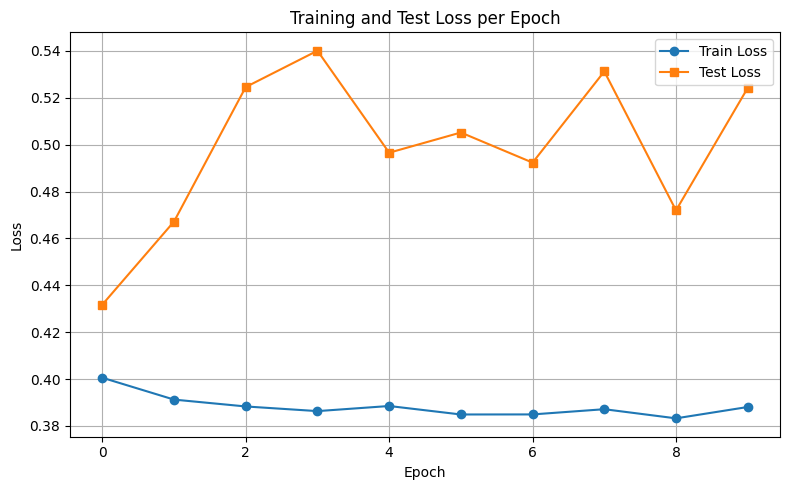

In [37]:
# Hyperparameters



input_length = 12000
model = CNNClassifier(input_length=input_length, num_layers=num_layers, base_channels=base_channels)
model = model.to(device)
wandb.watch(model, log='all', log_freq=10)
# print(model)
# Train
model = train_model(model, train_loader, test_loader, epochs=epochs, lr=learning_rate)



 Evaluation Metrics:
Accuracy:  0.6218
Precision: 0.6774
Recall:    0.8145
F1 Score:  0.7397
AUC:       0.6332
AP:        0.7249


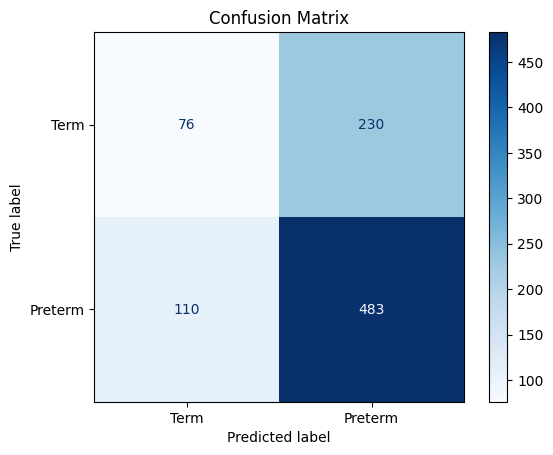

In [38]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, average_precision_score, ConfusionMatrixDisplay
)

def evaluate_model(model, test_loader, device='cuda'):
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.unsqueeze(1).to(device)
            y_batch = y_batch.to(device).unsqueeze(1)

            logits = model(x_batch)
            probs = torch.sigmoid(logits)

            all_probs.extend(probs.cpu().numpy().flatten())
            all_preds.extend((probs > 0.5).int().cpu().numpy().flatten())
            all_labels.extend(y_batch.cpu().numpy().flatten())

    # Convert to NumPy arrays
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    y_score = np.array(all_probs)

    # Compute metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_score)
    ap = average_precision_score(y_true, y_score)

    print("\n Evaluation Metrics:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"AUC:       {auc:.4f}")
    print(f"AP:        {ap:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Term", "Preterm"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

evaluate_model(model, test_loader)
